# TMDB Movie Data Analysis 🎬

This project builds a full **Movie Data Analysis Pipeline** using Python, Pandas, TMDb API, and Matplotlib.  
It covers data extraction, cleaning, KPI analysis, and visualization — following a modular, production-grade design.


#### Importing Dependencies

In [14]:
#import dependencies
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
from dotenv import load_dotenv
import os
import time

### Data Extraction Section

In [15]:
#load api keys and base urls from .env file
load_dotenv()
api_key = os.getenv('API_KEY')
base_url = os.getenv('BASE_url')
#create list for movie ids
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513]


movies_data = []
# iterate between movie Ids, error handling for rate limit and fallback Mechanism
for movie_id in movie_ids:
    for attempt in range(3):
        try:
            url = f'{base_url}{movie_id}?api_key={api_key}&append_to_response=credits'
            r = requests.get(url)
            if r.status_code == 200:
                movies_data.append(r.json())
                break
            elif r.status_code == 429:
                print("Rate limit hit. Waiting 3 seconds...")
                time.sleep(3)
            else:
                print(f"Failed: {movie_id} (Status {r.status_code})")
                time.sleep(1)
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(1)


    time.sleep(0.3)  # ~3 requests per second max to be safe
#create Data frame
df = pd.DataFrame(movies_data)
print(df.head())
# saving data using time stamps to prevent over_writing data everytime notebook runs.
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
df.to_csv(f'../data/raw/moviesData_{timestamp}.csv', index=False)


Failed: 0 (Status 404)
Failed: 0 (Status 404)
Failed: 0 (Status 404)
   adult                     backdrop_path  \
0  False  /7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg   
1  False  /vL5LR6WdxWPjLPFRLe133jXWsh5.jpg   
2  False  /k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg   
3  False  /mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg   
4  False  /sCzcYW9h55WcesOqA12cgEr9Exw.jpg   

                               belongs_to_collection     budget  \
0  {'id': 86311, 'name': 'The Avengers Collection...  356000000   
1  {'id': 87096, 'name': 'Avatar Collection', 'po...  237000000   
2  {'id': 10, 'name': 'Star Wars Collection', 'po...  245000000   
3  {'id': 86311, 'name': 'The Avengers Collection...  300000000   
4                                               None  200000000   

                                              genres  \
0  [{'id': 12, 'name': 'Adventure'}, {'id': 878, ...   
1  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
2  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   
3  [{'id': 12, 'name': 'Adv

#### Data Cleaning 

In [ ]:
#load data 
load_data = pd.read_csv('../data/raw/moviesData_08-04-2025_10-07-51.csv')

#create dataframe
df = pd.DataFrame(load_data)
#df.head()

#drop unnecessary columns
drop_cols = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
df = df.drop(columns=drop_cols)
# df.head(3) 
# Extracting nested columns in the data
df['genres'] = df['genres'].apply(lambda x: "|".join([d['name'] for d in ast.literal_eval(x)]) if pd.notnull(x) else np.nan)

df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else np.nan)

df['production_countries'] = df['production_countries'].apply(lambda x: "|".join([d['name'] for d in ast.literal_eval(x)]) if pd.notnull(x) else np.nan)

df['production_companies'] = df['production_companies'].apply(lambda x: "|".join([d['name'] for d in ast.literal_eval(x)]) if pd.notnull(x) else np.nan)

df['spoken_languages'] = df['spoken_languages'].apply(lambda x: "|".join([d['english_name'] for d in ast.literal_eval(x)]) if pd.notnull(x) else np.nan)

#new columns inclusion from nested 

df['credits_parsed'] = df['credits'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else {})
# Function to get cast
def get_full_cast(credit):
    cast_list = credit.get('cast', [])
    names = [member.get('name') for member in cast_list if member.get('name')]
    return '|'.join(names) if names else None

# Function to get director
def get_director(credit):
    crew_list = credit.get('crew', [])
    for member in crew_list:
        if member.get('job') == 'Director':
            return member.get('name')
    return None

# Function to get cast size
def get_cast_size(credit):
    cast_list = credit.get('cast', [])
    return len(cast_list)

# Function to get crew size
def get_crew_size(credit):
    crew_list = credit.get('crew', [])
    return len(crew_list)

# Apply functions to create new columns
df['cast'] = df['credits_parsed'].apply(get_full_cast)
df['director'] = df['credits_parsed'].apply(get_director)
df['cast_size'] = df['credits_parsed'].apply(get_cast_size)
df['crew_size'] = df['credits_parsed'].apply(get_crew_size)
df.drop(columns=['credits_parsed'], inplace=True)

#Re-arrange multiple values column to prevent abnomaly 
df['genres'] = df['genres'].apply(lambda x: '|'.join(sorted(x.split('|'))))
df['production_countries'] = df['production_countries'].apply(lambda x: '|'.join(sorted(x.split('|'))))
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: '|'.join(sorted(x.split('|'))))


In [17]:
#Display value counts on modified columns
print(df['genres'].value_counts())
print(df['belongs_to_collection'].value_counts())
print(df['production_countries'].value_counts())
print(df['production_companies'].value_counts())
print(df['spoken_languages'].value_counts())

genres
Action|Adventure|Science Fiction             7
Action|Adventure|Science Fiction|Thriller    2
Action|Adventure|Fantasy|Science Fiction     1
Drama|Romance                                1
Adventure|Animation|Drama|Family             1
Action|Crime|Thriller                        1
Adventure|Fantasy                            1
Adventure|Animation|Comedy|Family|Fantasy    1
Adventure|Animation|Family|Fantasy           1
Family|Fantasy|Romance                       1
Action|Adventure|Animation|Family            1
Name: count, dtype: int64
belongs_to_collection
The Avengers Collection                4
Star Wars Collection                   2
Frozen Collection                      2
Jurassic Park Collection               2
Avatar Collection                      1
The Lion King (Reboot) Collection      1
The Fast and the Furious Collection    1
Black Panther Collection               1
Harry Potter Collection                1
The Incredibles Collection             1
Name: count, dtype

In [18]:
# Convert budget, id, popularity to numeric
df['budget'] = pd.to_numeric(df['budget'],errors='coerce')
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['id'] = pd.to_numeric(df['id'],errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
# df.head(1)

df[['budget', 'revenue', 'runtime']] = df[['budget', 'revenue', 'runtime']].replace(0, np.nan)
# budget and revenue transformation
df['budget_musd'] = df['budget'] / 1e6
df['revenue_musd'] = df['revenue'] / 1e6


In [19]:
# Find movies with vote_count = 0
zero_votes = df[df['vote_count'] == 0]

# See what their vote_average looks like
print(zero_votes[['title', 'vote_count', 'vote_average']])

# Adjust: Set vote_average to NaN where vote_count is 0

df.loc[df['vote_count'] == 0, 'vote_average'] = np.nan


Empty DataFrame
Columns: [title, vote_count, vote_average]
Index: []


In [20]:
#using placeholders to handle missing data 
placeholders = ['No Data', '', 'nan']
df['overview'] = df['overview'].replace(placeholders, np.nan)
df['tagline'] = df['tagline'].replace(placeholders, np.nan)
df = df.drop_duplicates()
df = df.dropna(subset=['id', 'title'])
df = df[df.notna().sum(axis=1) >= 10]
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'])

#finalizing columns needed
final_cols = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size'
]
df = df[final_cols]
df = df.reset_index(drop=True)

#### KPI Implementation & Analysis 

In [21]:
# 1. Create Helper Columns, to define profit and roi
df['profit'] = df['revenue_musd'] - df['budget_musd']
df['roi'] = df['revenue_musd'] / df['budget_musd']

# 2. Define a Ranking Function
def rank_movies(df, sort_by, ascending=False, min_budget_musd=None, min_votes=None, top_n=5):
    temp = df.copy()
    if min_budget_musd:
        temp = temp[temp['budget_musd'] >= min_budget_musd]
    if min_votes:
        temp = temp[temp['vote_count'] >= min_votes]
    temp = temp.sort_values(by=sort_by, ascending=ascending)
    return temp[['title', sort_by]].head(top_n)

In [22]:
# 3. KPI Calculations

# Highest Revenue
print("\nTop 5 Highest Revenue Movies:")
print(rank_movies(df, sort_by='revenue_musd', ascending=False))

# Highest Budget
print("\nTop 5 Highest Budget Movies:")
print(rank_movies(df, sort_by='budget_musd', ascending=False))

# Highest Profit
print("\nTop 5 Highest Profit Movies:")
print(rank_movies(df, sort_by='profit', ascending=False))

# Lowest Profit
print("\nTop 5 Lowest Profit Movies:")
print(rank_movies(df, sort_by='profit', ascending=True))

# Highest ROI (only budget ≥ 10M)
print("\nTop 5 Highest ROI Movies (budget ≥ 10M):")
print(rank_movies(df, sort_by='roi', ascending=False, min_budget_musd=10))

# Lowest ROI (only budget ≥ 10M)
print("\nTop 5 Lowest ROI Movies (budget ≥ 10M):")
print(rank_movies(df, sort_by='roi', ascending=True, min_budget_musd=10))

# Most Voted Movies
print("\nTop 5 Most Voted Movies:")
print(rank_movies(df, sort_by='vote_count', ascending=False))

# Highest Rated Movies (only movies ≥ 10 votes)
print("\nTop 5 Highest Rated Movies (votes ≥ 10):")
print(rank_movies(df, sort_by='vote_average', ascending=False, min_votes=10))

# Lowest Rated Movies (only movies ≥ 10 votes)
print("\nTop 5 Lowest Rated Movies (votes ≥ 10):")
print(rank_movies(df, sort_by='vote_average', ascending=True, min_votes=10))

# Most Popular Movies
print("\nTop 5 Most Popular Movies:")
print(rank_movies(df, sort_by='popularity', ascending=False))



Top 5 Highest Revenue Movies:
                          title  revenue_musd
1                        Avatar   2923.706026
0             Avengers: Endgame   2799.439100
4                       Titanic   2264.162353
2  Star Wars: The Force Awakens   2068.223624
3        Avengers: Infinity War   2052.415039

Top 5 Highest Budget Movies:
                          title  budget_musd
9       Avengers: Age of Ultron        365.0
0             Avengers: Endgame        356.0
3        Avengers: Infinity War        300.0
6                 The Lion King        260.0
2  Star Wars: The Force Awakens        245.0

Top 5 Highest Profit Movies:
                          title       profit
1                        Avatar  2686.706026
0             Avengers: Endgame  2443.439100
4                       Titanic  2064.162353
2  Star Wars: The Force Awakens  1823.223624
3        Avengers: Infinity War  1752.415039

Top 5 Lowest Profit Movies:
                       title       profit
9    Avengers: Age of 

In [23]:
# 4. Advanced Movie Filtering & Search Queries

# Search 1: Best-rated Science Fiction Action movies starring Bruce Willis
query1 = df[
    df['genres'].str.contains('Science Fiction') &
    df['genres'].str.contains('Action') &
    df['cast'].str.contains('Bruce Willis', na=False)
]
query1 = query1.sort_values(by='vote_average', ascending=False)
print("\nBest-rated Science Fiction Action Movies starring Bruce Willis:")
print(query1[['title', 'vote_average']].head())

# Search 2: Movies starring Uma Thurman directed by Quentin Tarantino
query2 = df[
    df['cast'].str.contains('Uma Thurman', na=False) &
    df['director'].str.contains('Quentin Tarantino', na=False)
]
query2 = query2.sort_values(by='runtime', ascending=True)
print("\nMovies starring Uma Thurman directed by Quentin Tarantino:")
print(query2[['title', 'runtime']].head())



Best-rated Science Fiction Action Movies starring Bruce Willis:
Empty DataFrame
Columns: [title, vote_average]
Index: []

Movies starring Uma Thurman directed by Quentin Tarantino:
Empty DataFrame
Columns: [title, runtime]
Index: []


In [24]:
# 5. Franchise vs Standalone Movie Performance
df['is_franchise'] = df['belongs_to_collection'].notna()

franchise_stats = df.groupby('is_franchise').agg({
    'revenue_musd': 'mean',
    'roi': 'median',
    'budget_musd': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean'
}).rename(index={True: 'Franchise', False: 'Standalone'})

print("\nFranchise vs Standalone Movie Performance:")
print(franchise_stats)


Franchise vs Standalone Movie Performance:
              revenue_musd       roi  budget_musd  popularity  vote_average
is_franchise                                                               
Standalone     1765.139159  9.617018      180.000   25.055400      7.452500
Franchise      1682.641971  7.786109      219.875   20.331431      7.378625


In [25]:
# 6. Most Successful Franchises
franchise_success = df.dropna(subset=['belongs_to_collection']).groupby('belongs_to_collection').agg({
    'id': 'count',  # Number of movies
    'budget_musd': ['sum', 'mean'],
    'revenue_musd': ['sum', 'mean'],
    'vote_average': 'mean'
}).sort_values(('revenue_musd', 'sum'), ascending=False)

print("\nMost Successful Movie Franchises:")
print(franchise_success.head())


Most Successful Movie Franchises:
                            id budget_musd         revenue_musd               \
                         count         sum    mean          sum         mean   
belongs_to_collection                                                          
The Avengers Collection      4      1241.0  310.25  7776.073348  1944.018337   
Star Wars Collection         2       445.0  222.50  3400.922454  1700.461227   
Jurassic Park Collection     2       320.0  160.00  2982.003740  1491.001870   
Avatar Collection            1       237.0  237.00  2923.706026  2923.706026   
Frozen Collection            2       300.0  150.00  2727.902485  1363.951242   

                         vote_average  
                                 mean  
belongs_to_collection                  
The Avengers Collection       7.86975  
Star Wars Collection          7.02100  
Jurassic Park Collection      6.61500  
Avatar Collection             7.58700  
Frozen Collection             7.24800  


In [26]:
# 7. Most Successful Directors
director_success = df.dropna(subset=['director']).groupby('director').agg({
    'id': 'count',  # Number of movies directed
    'revenue_musd': 'sum',
    'vote_average': 'mean'
}).sort_values('revenue_musd', ascending=False)

print("\nMost Successful Directors:")
print(director_success.head())


Most Successful Directors:
               id  revenue_musd  vote_average
director                                     
James Cameron   2   5187.868379        7.7460
Joss Whedon     2   2924.219209        7.5025
Joe Russo       1   2799.439100        8.2380
J.J. Abrams     1   2068.223624        7.2620
Anthony Russo   1   2052.415039        8.2360


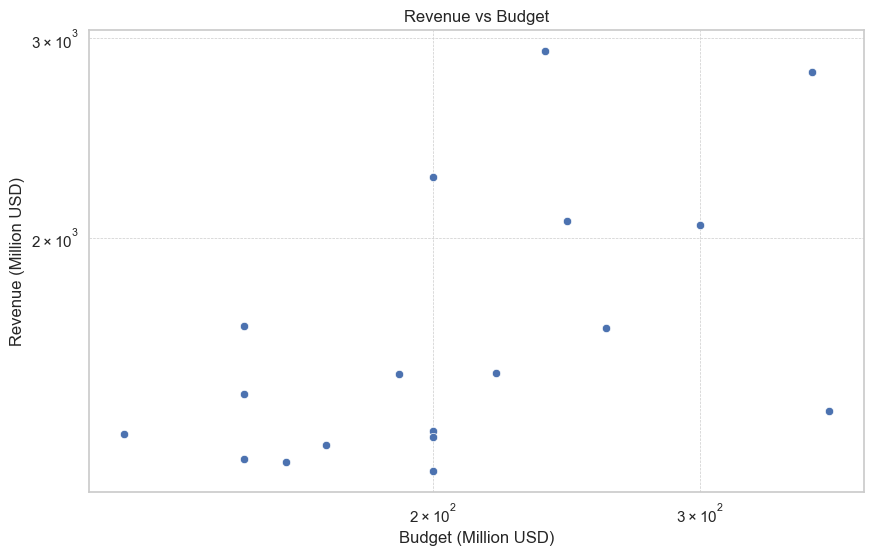

In [27]:
# Add release_year column, to make ease of calibration 
df['release_year'] = df['release_date'].dt.year

# Set a style
sns.set(style="whitegrid")

# 1. Revenue vs Budget Trends
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='budget_musd', y='revenue_musd')
plt.title('Revenue vs Budget')
plt.xlabel('Budget (Million USD)')
plt.ylabel('Revenue (Million USD)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

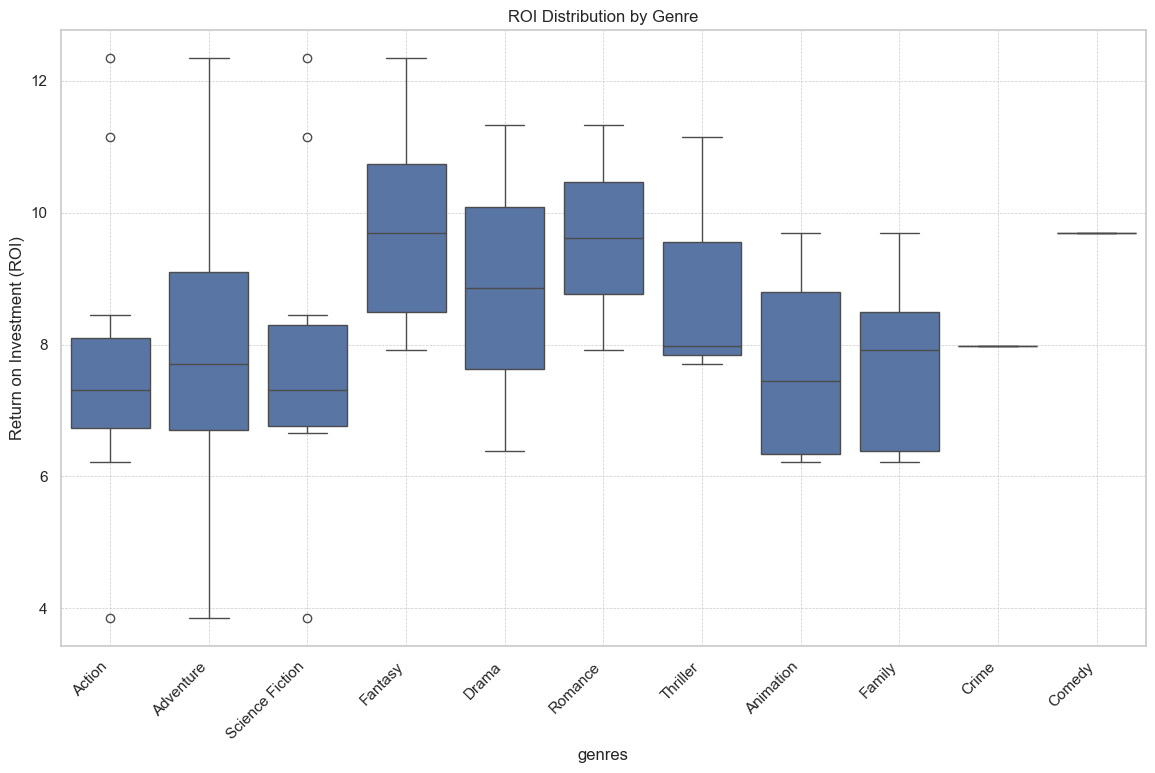

In [ ]:
# 2. ROI Distribution by Genre
# We need to explode genres because multiple genres are combined with "|"
df_exploded = df.dropna(subset=['genres']).copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genres')

plt.figure(figsize=(14,8))
sns.boxplot(data=df_exploded, x='genres', y='roi')
plt.title('ROI Distribution by Genre')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Return on Investment (ROI)')
plt.grid(True, ls="--", linewidth=0.5)
plt.show()

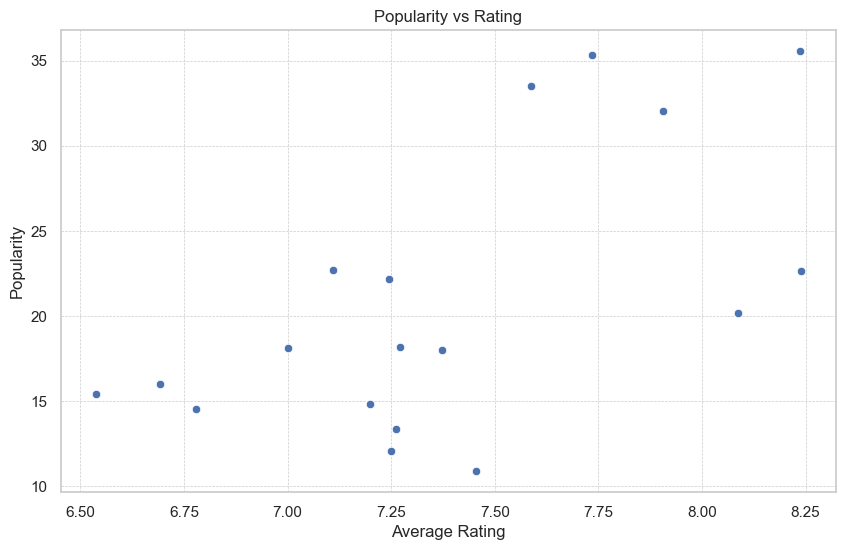

In [29]:
# 3. Popularity vs Rating
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='vote_average', y='popularity')
plt.title('Popularity vs Rating')
plt.xlabel('Average Rating')
plt.ylabel('Popularity')
plt.grid(True, ls="--", linewidth=0.5)
plt.show()

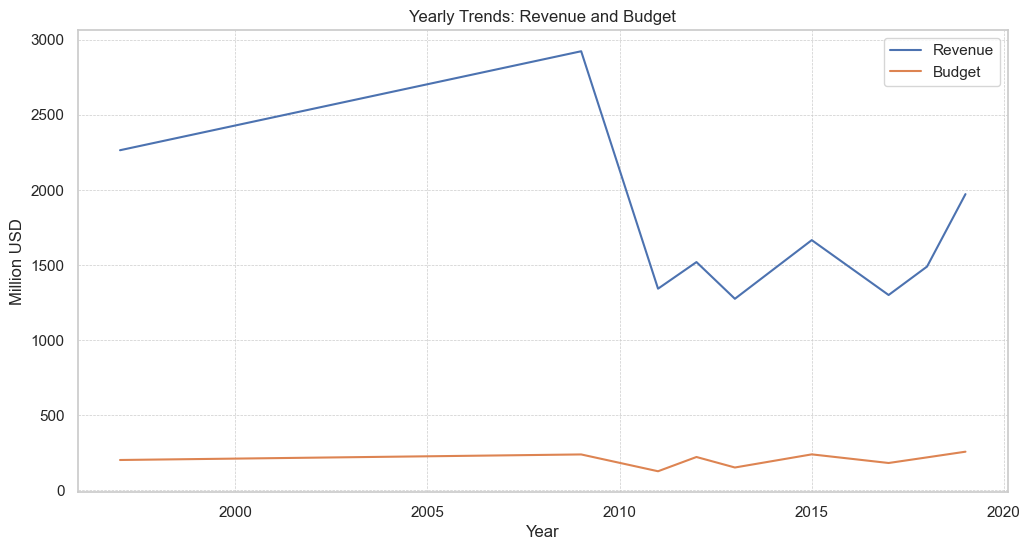

In [30]:
# 4. Yearly Trends in Box Office Performance
yearly_revenue = df.groupby('release_year').agg({
    'revenue_musd': 'mean',
    'budget_musd': 'mean',
    'popularity': 'mean'
}).dropna()

plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_revenue, x=yearly_revenue.index, y='revenue_musd', label='Revenue')
sns.lineplot(data=yearly_revenue, x=yearly_revenue.index, y='budget_musd', label='Budget')
plt.title('Yearly Trends: Revenue and Budget')
plt.xlabel('Year')
plt.ylabel('Million USD')
plt.legend()
plt.grid(True, ls="--", linewidth=0.5)
plt.show()

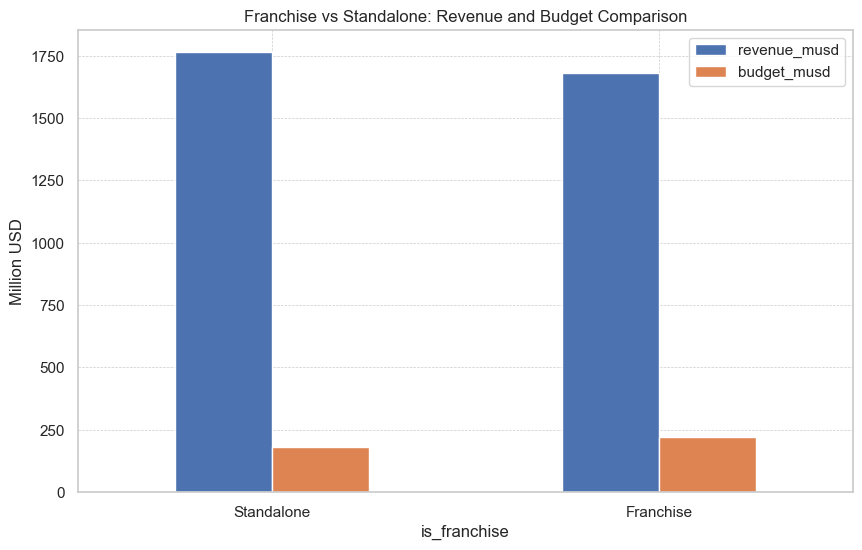

In [31]:
# 5. Comparison of Franchise vs Standalone Success
df['is_franchise'] = df['belongs_to_collection'].notna()

franchise_vs_standalone = df.groupby('is_franchise').agg({
    'revenue_musd': 'mean',
    'budget_musd': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean'
}).rename(index={True: 'Franchise', False: 'Standalone'})

franchise_vs_standalone[['revenue_musd', 'budget_musd']].plot(
    kind='bar', figsize=(10,6)
)
plt.title('Franchise vs Standalone: Revenue and Budget Comparison')
plt.ylabel('Million USD')
plt.xticks(rotation=0)
plt.grid(True, ls="--", linewidth=0.5)
plt.show()